## Subcategory SVM

In [12]:
from  sklearn import svm as sksvm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import datasets
import joblib
import dotenv
import os


In [2]:
dotenv.load_dotenv()
HF_TOKEN = os.environ['HF_TOKEN']
DATASET_LINK = os.environ['DATASET_LINK']
SEED = 42
TRAINING = False
datasetTotal = datasets.load_dataset(DATASET_LINK, token=HF_TOKEN)

In [3]:
valSet = pd.DataFrame(datasetTotal['validation'])[['subcategory', 'label', 'category','type']]
trainSet = pd.DataFrame(datasetTotal['train'])[['subcategory', 'label', 'category', 'type']]

In [4]:
subcatTrain = set(trainSet['subcategory'])
subcatVal = set(valSet['subcategory'])

subcat = subcatTrain.union(subcatVal)
print(len(subcat))
aliasesSub = {k:i for i,k in enumerate(subcat)}
print(aliasesSub)

catTrain = set(trainSet['category'])
catVal = set(valSet['category'])

cat = catTrain.union(catVal)
print(len(cat))

aliasesCat = {k:i for i,k in enumerate(cat)}
print(aliasesCat)

typeTrain = set(trainSet['type'])
typeVal = set(valSet['type'])

typeTot = typeTrain.union(typeVal)
aliasesType = {k:i for i,k in enumerate(typeTot)}
print(len(typeTot))
aliasLabel = {
    'cultural exclusive':0,
    'cultural agnostic':1,
    'cultural representative':2
}


112
{'music genre': 0, 'body language': 1, 'record label': 2, 'historian': 3, 'station': 4, 'religious book': 5, 'actor': 6, 'choreographer': 7, 'geographic location': 8, 'film studio': 9, 'television': 10, 'tradition': 11, 'archive': 12, 'animation studio': 13, 'happening': 14, 'historical event': 15, 'mores': 16, 'musical group': 17, 'politician': 18, 'literary award': 19, 'production company': 20, 'film producer': 21, 'mountain': 22, 'sports club': 23, 'animation technique': 24, 'publisher': 25, 'law': 26, 'artist': 27, 'architect': 28, 'drink': 29, 'art movement': 30, 'government': 31, 'film director': 32, 'architectural structure': 33, 'athlete': 34, 'writing style': 35, 'religious movement': 36, 'philosopher': 37, 'building': 38, 'dance': 39, 'poet': 40, 'photographer': 41, 'dish': 42, 'transport company': 43, 'philosophical movement': 44, 'sports equipment': 45, 'musician': 46, 'plant': 47, 'film genre': 48, 'designer': 49, 'religion': 50, 'sports team': 51, 'neighborhood': 52, 

In [5]:
subCategoryEncodingTrain = np.zeros((trainSet.shape[0], len(subcat)), dtype=int)
categoryEncodingTrain = np.zeros((trainSet.shape[0], len(cat)), dtype=int)
typeEncodingTrain = np.zeros((trainSet.shape[0], len(typeTot)), dtype=int)

finalTrainLabel = trainSet['label'].apply(lambda x: aliasLabel[x])

for i in range(trainSet.shape[0]):
    subCategoryEncodingTrain[i][aliasesSub[trainSet['subcategory'].iloc[i]]] = 1
    categoryEncodingTrain[i][aliasesCat[trainSet['category'].iloc[i]]] = 1
    typeEncodingTrain[i][aliasesType[trainSet['type'].iloc[i]]] = 1
    
finalTrainData = np.concatenate((subCategoryEncodingTrain, categoryEncodingTrain, typeEncodingTrain), axis=1)
print(finalTrainData.shape)

(6251, 133)


In [6]:
subCategoryEncodingVal = np.zeros((valSet.shape[0], len(subcat)), dtype=int)
categoryEncodingVal = np.zeros((valSet.shape[0], len(cat)), dtype=int)
typeEncodingVal = np.zeros((valSet.shape[0], len(typeTot)), dtype=int)

finalValLabel = valSet['label'].apply(lambda x: aliasLabel[x])

for i in range(valSet.shape[0]):
    subCategoryEncodingVal[i][aliasesSub[valSet['subcategory'].iloc[i]]] = 1
    categoryEncodingVal[i][aliasesCat[valSet['category'].iloc[i]]] = 1
    typeEncodingVal[i][aliasesType[valSet['type'].iloc[i]]] = 1
    
finalValData = np.concatenate((subCategoryEncodingVal, categoryEncodingVal, typeEncodingVal), axis=1)
print(finalValData.shape)

(300, 133)


In [7]:
import sklearn.svm


def trainPass(scale: float, 
              gamma: float, 
              kernel: str, 
              features: np.ndarray, 
              labels: np.ndarray, 
              validation_features: np.ndarray, 
              validation_labels: np.ndarray
              )->tuple[float, sklearn.svm.SVC]:
    modelSubcategory = sksvm.SVC(kernel=kernel, 
                                C=scale, 
                                gamma=gamma,
                                class_weight={
                                        2:0.2700,
                                        1:0.2994,
                                        0:0.4305
                                    }, 
                                probability=True, 
                                random_state=SEED,
                                max_iter=10000)
    modelSubcategory.fit(features, labels)
    accuracy_score = modelSubcategory.score(validation_features, validation_labels)
    return accuracy_score, modelSubcategory

In [8]:
# if TRAINING:
#     bestScore = 0
#     bestModel = None
#     for k in ['rbf']:
#         for s in np.linspace(1,1,1):
#             for c in np.linspace(10,10,1):
#                 scoreValidation, model =  trainPass(c,s,k,
#                                           finalTrainData,
#                                           finalTrainLabel,
#                                           finalValData,
#                                           finalValLabel)
#                 if scoreValidation > bestScore:
#                     bestModel = model
#                     bestScore = scoreValidation
#                 print(f'Kernel: {k}, C: {c:.4f}, Gamma: {s:.4f} -> {scoreValidation}')
#     print(f"Accurecy: {bestScore*100:.4f}")
#     print(bestModel)

if TRAINING:
    score, bestModel = trainPass(10,1,'rbf',
                                 finalTrainData,
                                 finalTrainLabel,
                                 finalValData,
                                 finalValLabel)
    
    print(f"Accuracy: {score*100:.4f}%")            

Best model: kernel='rbf', C=10, gamma=1

In [9]:
if TRAINING:
    joblib.dump(bestModel, 'categorySVCWeights.pkl')

In [10]:
if not TRAINING:
    svm = joblib.load('categorySVCWeights.pkl')
else:
    svm = bestModel
    
results = svm.predict_proba(finalValData)
confidence = results[np.arange(results.shape[0]), np.argmax(results, axis=1)]*100

print(f'Max confidence: {confidence.max():.4f}%')
print(f'Min confidence: {confidence.min():.4f}%')
print(f'Mean confidence: {confidence.mean():.4f}%')
print(f'Std confidence: {confidence.std():.4f}%')

Max confidence: 71.5127%
Min confidence: 36.6784%
Mean confidence: 50.0850%
Std confidence: 7.4004%


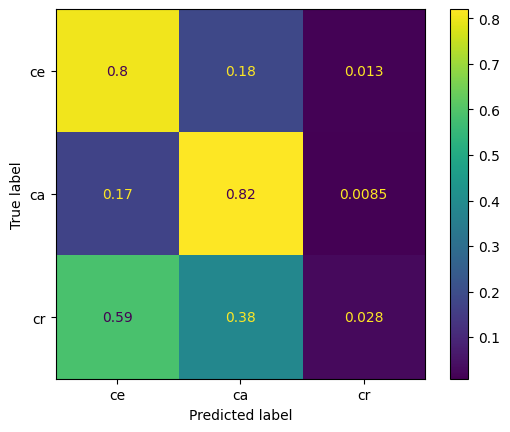

In [22]:
predictions = svm.predict(finalValData)

cfm = confusion_matrix(y_true=finalValLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()

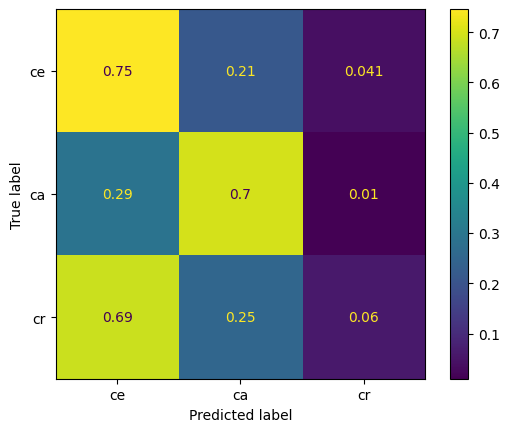

In [23]:
predictions = svm.predict(finalTrainData)

cfm = confusion_matrix(y_true=finalTrainLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()